# Drift detection on Image inputs



In [1]:
import IPython
import sys
sys.path.insert(0, '../')

import copy
import tqdm
import torchvision
import functools
import torch
from typing import Optional, Any
import torch
import math
import pytorch_lightning as pl
import torchdrift
import sklearn.manifold

%matplotlib inline
from matplotlib import pyplot


The top part is very close to the sample notebook.

## Load data

In order to experiment, we need a dataset.

Because we will want to apply transformations to simulate input drift, we split the PyTorch data loading chain a bit differently than usually done: Instead of normalizing the channels to zero mean / unit variance (on imagenet) in the dataset augmentation, we do this in an auxiliary function in the model just before feeding a batch.

We implement a `LightningDataModule` but with an important additional `default_dataloader` method that allows us to liberally choose the number of samples and the batch size. We will later use the additional transform to generate a drifted dataset on the fly.

We grab an ants versus bees dataset from the PyTorch tutorials.


In [2]:
torchvision.datasets.utils.download_and_extract_archive('https://download.pytorch.org/tutorial/hymenoptera_data.zip', 'data/')


# these are the standard transforms without the normalization (which we move into the model.step/predict before the forward)
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor()])
val_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=256),
    torchvision.transforms.CenterCrop(size=(224, 224)),
    torchvision.transforms.ToTensor()])


class OurDataModule(pl.LightningDataModule):
    def __init__(self, parent: Optional['OurDataModule']=None, additional_transform=None):
        if parent is None:
            self.train_dataset = torchvision.datasets.ImageFolder('./data/hymenoptera_data/train/',
                                                                  transform=train_transform)
            self.val_dataset = torchvision.datasets.ImageFolder('./data/hymenoptera_data/val/',
                                                                  transform=val_transform)
            self.test_dataset = torchvision.datasets.ImageFolder('./data/hymenoptera_data/test/',
                                                                  transform=val_transform)
            self.train_batch_size = 4
            self.val_batch_size = 128
            self.additional_transform = None
        else:
            self.train_dataset = parent.train_dataset
            self.val_dataset = parent.val_dataset
            self.test_dataset = parent.test_dataset
            self.train_batch_size = parent.train_batch_size
            self.val_batch_size = parent.val_batch_size
            self.additional_transform = additional_transform
        if additional_transform is not None:
            self.additional_transform = additional_transform
        
        self.prepare_data()
        self.setup('fit')
        self.setup('test')

    def setup(self, typ):
        pass
    
    def collate_fn(self, batch):
        batch = torch.utils.data._utils.collate.default_collate(batch)
        if self.additional_transform:
            batch = (self.additional_transform(batch[0]), *batch[1:])
        return batch
    
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.train_batch_size, 
                                           num_workers=4, shuffle=True, collate_fn=self.collate_fn)
    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.val_batch_size,
                                           num_workers=4, shuffle=False, collate_fn=self.collate_fn)
    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.val_batch_size,
                                           num_workers=4, shuffle=False, collate_fn=self.collate_fn)

    def default_dataloader(self, batch_size=None, num_samples=None, shuffle=True):
        dataset = self.val_dataset
        if batch_size is None:
            batch_size = self.val_batch_size
        replacement = num_samples is not None
        if shuffle:
            sampler = torch.utils.data.RandomSampler(dataset, replacement=replacement, num_samples=num_samples)
        else:
            sampler = None
        return torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=sampler,
                                           collate_fn=self.collate_fn)


datamodule = OurDataModule()


Using downloaded and verified file: data/hymenoptera_data.zip
Extracting data/hymenoptera_data.zip to data/


# Build a model

We use the TorchVision ResNet18 as our starting point.

Note that while we train a model here, in the end we use only the feature extractor for the drift detection, but we want to create the realistic situation where you have a classification model.
Nothing here is specific to drift detection except.

In [3]:
feature_extractor = torchvision.models.resnet18(pretrained=True)
feature_extractor.fc = torch.nn.Identity()

In [4]:
class Classifier(pl.LightningModule):
    def __init__(self, base_classifier):
        super().__init__()
        self.backbone = base_classifier
        self.backbone.eval()
        for p in self.backbone.parameters():
            p.requires_grad_(False)
        self.classifier = torch.nn.Linear(512, 2)

    def normalize(self, x: torch.Tensor):
        # We pull the normalization, usually done in the dataset into the model forward
        x = torchvision.transforms.functional.normalize(x, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        return x

    def forward(self, x: torch.Tensor):
        x = self.normalize(x)
        y = self.backbone(x)
        return self.classifier(y)

    def training_step(self, batch: torch.Tensor, batch_idx: int):
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        acc = (y_hat.max(1).indices == y).float().mean()
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def validation_step(self, batch: torch.Tensor, batch_idx: int):
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        acc = (y_hat.max(1).indices == y).float().mean()
        self.log('val_loss', loss)
        self.log('val_acc', acc)
        return loss

    def test_step(self, batch: torch.Tensor, batch_idx: int):
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        acc = (y_hat.max(1).indices == y).float().mean()
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return loss

    def predict(self, batch: Any, batch_idx: Optional[int]=None, dataloader_idx: Optional[int] = None):
        return self(batch)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

model = Classifier(feature_extractor)

We finetune our network a bit (we set the requires grad to False for the resnet):

In [5]:
trainer = pl.Trainer(max_epochs=3, gpus=1, checkpoint_callback=False, logger=False)
trainer.fit(model, datamodule)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type   | Params
--------------------------------------
0 | backbone   | ResNet | 11.2 M
1 | classifier | Linear | 1.0 K 
--------------------------------------
1.0 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)
Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


1

In [6]:

trainer.test(model, datamodule=datamodule)

Widget Javascript not detected.  It may not be installed or enabled properly.


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8888888955116272, 'test_loss': 0.24882762134075165}
--------------------------------------------------------------------------------


[{'test_loss': 0.24882762134075165, 'test_acc': 0.8888888955116272}]

## Simulating drifted data

You already know how this works, but we might show a sample nonetheless.

In [7]:
def corruption_function(x: torch.Tensor):
    return torchdrift.data.functional.gaussian_blur(x, severity=2)

ind_datamodule = datamodule
ood_datamodule = OurDataModule(parent=datamodule, additional_transform=corruption_function)

In [8]:
inputs, _ = next(iter(datamodule.default_dataloader(shuffle=True)))
inputs_ood = corruption_function(inputs)

N = 6
model.eval()
inps = torch.cat([inputs[:N], inputs_ood[:N]])
model.cpu()
predictions = model.predict(inps).max(1).indices

predicted_labels = [["ant","bee"][p] for p in predictions]


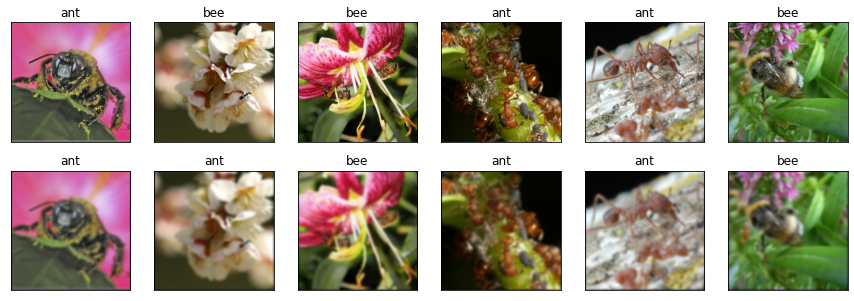

In [9]:
pyplot.figure(figsize=(15, 5))
for i in range(2 * N):
    pyplot.subplot(2, N, i + 1)
    pyplot.title(predicted_labels[i])
    pyplot.imshow(inps[i].permute(1, 2, 0))
    pyplot.xticks([])
    pyplot.yticks([])

For drift detection, we need a feature extractor (of course, we had one above, too, but let's play along and pretend we got the `model` from our colleague.

In [10]:


feature_extractor = copy.deepcopy(model)
feature_extractor.classifier = torch.nn.Identity()



# The drift detector




In [11]:
drift_detector = torchdrift.detectors.KernelMMDDriftDetector()



In [12]:
drift_detector.fit(datamodule.train_dataloader().dataset, feature_extractor)

100%|██████████| 8/8 [00:01<00:00,  4.32it/s]


We can then put the drift detector to action.


In [13]:
drift_detection_model = torch.nn.Sequential(
    feature_extractor,
    drift_detector
)

In [14]:
features = feature_extractor(inputs)
score = drift_detector(features)
p_val = drift_detector.compute_p_value(features)
score, p_val

(tensor(0.0135), tensor(0.0310))

In [15]:
feat = torch.cat([drift_detector.base_outputs, features])
N_base = drift_detector.base_outputs.size(0)
X_embedded = sklearn.manifold.TSNE(n_components=2).fit_transform(feat)

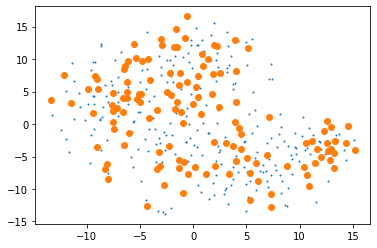

In [16]:
pyplot.scatter(X_embedded[:N_base, 0], X_embedded[:N_base, 1], s=1)
pyplot.scatter(X_embedded[N_base:, 0], X_embedded[N_base:, 1])


In [17]:
inputs_c = torchdrift.data.functional.speckle_noise(inputs)

In [18]:
features = feature_extractor(inputs_c)
score = drift_detector(features)
p_val = drift_detector.compute_p_value(features)

score, p_val

(tensor(0.0587), tensor(0.))

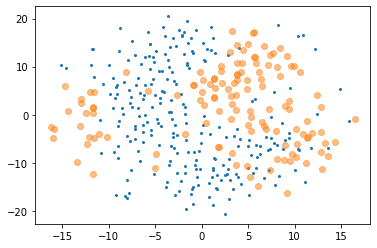

In [19]:
feat = torch.cat([drift_detector.base_outputs, features])
N_base = drift_detector.base_outputs.size(0)
X_embedded = sklearn.manifold.TSNE(n_components=2).fit_transform(feat)
pyplot.scatter(X_embedded[:N_base, 0], X_embedded[:N_base, 1], s=4)
pyplot.scatter(X_embedded[N_base:, 0], X_embedded[N_base:, 1], alpha=0.5)


We can do more systematic experimentation.

While the statistical tests underpinning the drift detection could also produce P-values
(but double-check and find example that has non 0 p-value), we can also treat the test score as a value that can be thresholded for detection, giving the typical ROC curve.

100%|██████████| 50/50 [00:08<00:00,  5.87it/s]


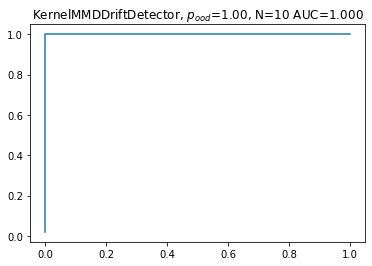

In [20]:
od_model = drift_detector
ind_datamodule = datamodule
ood_datamodule = OurDataModule(parent=datamodule, additional_transform=corruption_function)

ood_ratio = 1.0
sample_size = 10
experiment = torchdrift.utils.DriftDetectionExperiment(od_model, feature_extractor, ood_ratio=ood_ratio, sample_size=sample_size)
experiment.post_training(datamodule.train_dataloader().dataset)
auc, (fp, tp) = experiment.evaluate(ind_datamodule, ood_datamodule)
pyplot.plot(fp, tp)
pyplot.title(label=f'{type(od_model).__name__}, $p_{{ood}}$={ood_ratio:.2f}, N={sample_size} AUC={auc:.3f}')
pyplot.show()

# Dimension Reduction & KS tests

In [21]:
red = torchdrift.reducers.pca.PCAReducer()
detector = torchdrift.detectors.ks.KSDriftDetector()

feature_extractor_red = torch.nn.Sequential(feature_extractor, red).cuda()

In [22]:
detector.fit(datamodule.train_dataloader().dataset, feature_extractor_red)

100%|██████████| 8/8 [00:00<00:00,  9.55it/s]


In [23]:
detector.compute_p_value(feature_extractor_red(inputs.cuda()))

0.00037407620293727423

100%|██████████| 50/50 [00:03<00:00, 13.74it/s]


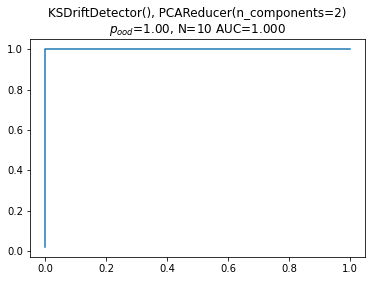

In [24]:
experiment = torchdrift.utils.DriftDetectionExperiment(detector, feature_extractor_red, ood_ratio=ood_ratio, sample_size=sample_size)
experiment.post_training(datamodule.train_dataloader().dataset)
auc, (fp, tp) = experiment.evaluate(ind_datamodule, ood_datamodule)
pyplot.plot(fp, tp)
pyplot.title(label=f'{detector}, {red}\n$p_{{ood}}$={ood_ratio:.2f}, N={sample_size} AUC={auc:.3f}')
pyplot.show()

# UAE Experiment

In [25]:

feature_extractor_red = torch.nn.Sequential(
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torch.nn.Conv2d(3, 128, kernel_size=5, padding=2, stride=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(128, 256, kernel_size=5, padding=2, stride=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(256, 1024, kernel_size=5, padding=2, stride=2),
    torch.nn.ReLU(),
    torch.nn.AdaptiveMaxPool2d(8),
    torch.nn.Flatten(),
    torch.nn.Linear(1024*8*8, 512)
     ).cuda().eval()

for m in feature_extractor_red:
    if isinstance(m, (torch.nn.Conv2d, torch.nn.Linear)):
        torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        torch.nn.init.zeros_(m.bias)

100%|██████████| 100/100 [00:07<00:00, 14.02it/s]


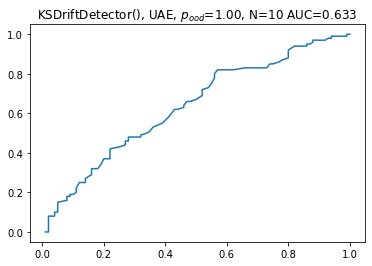

In [26]:
detector = torchdrift.detectors.ks.KSDriftDetector()
experiment = torchdrift.utils.DriftDetectionExperiment(detector, feature_extractor_red, ood_ratio=ood_ratio, sample_size=sample_size)
experiment.post_training(datamodule.train_dataloader().dataset)
auc, (fp, tp) = experiment.evaluate(ind_datamodule, ood_datamodule, num_runs=100)
pyplot.plot(fp, tp)
pyplot.title(label=f'{detector}, UAE, $p_{{ood}}$={ood_ratio:.2f}, N={sample_size} AUC={auc:.3f}')
pyplot.show()